The objective here is to develop a machine learning model on bussiness prospective to classifies arguments about the mental health challenges that a person struggle with. The four categories are depression, suicide, alchoholism, and drug abuse.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB,CategoricalNB
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import re
from nltk.corpus import stopwords
import string
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import seaborn as sns
from nltk.stem import SnowballStemmer as sno
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score,cross_validate,GridSearchCV,train_test_split
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,VotingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import TruncatedSVD

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**Upload Data**

In [2]:
train=pd.read_csv('Train.csv')
test=pd.read_csv('Test.csv')

**Data Exploration:**

In [3]:
train.shape

(616, 3)

In [4]:
test.shape

(309, 2)

In [5]:
print('Train shape:',train.shape,'and number of null values are:',train.isnull().sum())
train.head()

Train shape: (616, 3) and number of null values are: ID       0
text     0
label    0
dtype: int64


,ID,text,label
0,SUAVK39Z,I feel that it was better I dieAm happy,Depression
1,9JDAGUV3,Why do I get hallucinations?,Drugs
2,419WR1LQ,I am stresseed due to lack of financial suppor...,Depression
3,6UY7DX6Q,Why is life important?,Suicide
4,FYC0FTFB,How could I be helped to go through the depres...,Depression


In [6]:
print('Test shape:',test.shape,'and number of null values are:',test.isnull().sum())
test.head()

Test shape: (309, 2) and number of null values are: ID      0
text    0
dtype: int64


,ID,text
0,02V56KMO,How to overcome bad feelings and emotions
1,03BMGTOK,I feel like giving up in life
2,03LZVFM6,I was so depressed feel like got no strength t...
3,0EPULUM5,I feel so low especially since I had no one to...
4,0GM4C5GD,can i be successful when I am a drug addict?


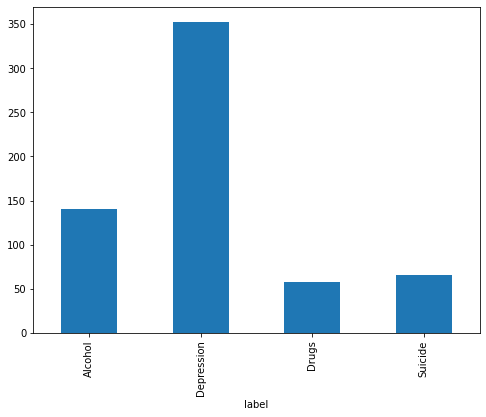

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
train.groupby('label').text.count().plot.bar(ylim=0)
plt.show()

# Text cleaning

In [8]:
corpus  = []
pstem = PorterStemmer()
for i in range(train['text'].shape[0]):
    #Remove unwanted words
    tweet = re.sub("[^a-zA-Z]", ' ', train['text'][i])
    #Transform words to lowercase
    tweet = tweet.lower()
    tweet = tweet.split()
    #Remove stopwords then Stemming it
    tweet = [pstem.stem(word) for word in tweet if not word in set(stopwords.words('english'))]
    tweet = ' '.join(tweet)
    #Append cleaned tweet to corpus
    corpus.append(tweet)

In [35]:
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [9]:
print(pd.DataFrame(corpus)[0].head())

0                    feel better dieam happi
1                               get hallucin
2    stresse due lack financi support school
3                                life import
4                      could help go depress
Name: 0, dtype: object


In [10]:
train['clean']=corpus

In [11]:
train.head(5)

,ID,text,label,clean
0,SUAVK39Z,I feel that it was better I dieAm happy,Depression,feel better dieam happi
1,9JDAGUV3,Why do I get hallucinations?,Drugs,get hallucin
2,419WR1LQ,I am stresseed due to lack of financial suppor...,Depression,stresse due lack financi support school
3,6UY7DX6Q,Why is life important?,Suicide,life import
4,FYC0FTFB,How could I be helped to go through the depres...,Depression,could help go depress


In [12]:
df=train
df['label'] = df['label'].factorize()[0]

In [13]:
df.head(5)

,ID,text,label,clean
0,SUAVK39Z,I feel that it was better I dieAm happy,0,feel better dieam happi
1,9JDAGUV3,Why do I get hallucinations?,1,get hallucin
2,419WR1LQ,I am stresseed due to lack of financial suppor...,0,stresse due lack financi support school
3,6UY7DX6Q,Why is life important?,2,life import
4,FYC0FTFB,How could I be helped to go through the depres...,0,could help go depress


In [14]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=3, norm='l2', encoding='latin-1', ngram_range=(1,2), stop_words='english')
features = tfidf.fit_transform(df.clean).toarray()
labels = df.label
features.shape

(616, 197)

In [15]:
terms = tfidf.get_feature_names()
# sum tfidf frequency of each term through documents
sums =  tfidf.fit_transform(df.clean).sum(axis=0)
# connecting term to its sums frequency
data = []
for col, term in enumerate(terms):
    data.append( (term, sums[0,col] ))

ranking = pd.DataFrame(data, columns=['term','rank'])
print(ranking.sort_values('rank', ascending=False))

               term       rank
61             feel  55.968182
38          depress  39.843269
3           alcohol  38.381857
164            stop  25.785003
99             life  24.650437
..              ...        ...
60              fee   1.510802
81          guidanc   1.468479
111        low self   1.456892
39     depress feel   1.407745
66   feel discourag   1.388885

[197 rows x 2 columns]


In [16]:
df.head()

,ID,text,label,clean
0,SUAVK39Z,I feel that it was better I dieAm happy,0,feel better dieam happi
1,9JDAGUV3,Why do I get hallucinations?,1,get hallucin
2,419WR1LQ,I am stresseed due to lack of financial suppor...,0,stresse due lack financi support school
3,6UY7DX6Q,Why is life important?,2,life import
4,FYC0FTFB,How could I be helped to go through the depres...,0,could help go depress


In [17]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.25, random_state=42)

# Model Training

**Xgboost Model :**

In [37]:
grid_values = {
        'max_depth': [3,5,6, 9],
        #'subsample': [0.9, 1.0],
        'learning_rate':[0.1,0.01,0.5],
        'n_estimators':[60,80,100,110],
    }

In [38]:
num_boost_round: [100, 250, 500]
eta: [0.05, 0.1, 0.3]
learning_rate:[0.1,0.01,0.5]

In [39]:
model=XGBClassifier(nthread = 4)

In [40]:
grid_clf_acc = GridSearchCV(model, param_grid = grid_values,scoring = 'neg_log_loss')
grid_clf_acc.fit(features, labels)

GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.1, 0.01, 0.5],
                         'max_depth': [3, 5, 6, 9],
                         'n_estimators': [60, 80, 100, 110]},
   

In [41]:
grid_clf_acc.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 110}

In [42]:
classifier=XGBClassifier(colsample_bytree= 0.9, max_depth= 6,n_estimators= 80, subsample= 0.9)
cv = cross_validate(estimator=classifier, X=features, y=labels,scoring = ('neg_log_loss','accuracy'), cv=3)

In [43]:
np.mean(cv['test_neg_log_loss']),np.mean(cv['test_accuracy'])

(-0.5058571764609002, 0.8213750098666036)

In [44]:
p=classifier.fit(X_train,y_train).predict_proba(X_test)

In [45]:
log_loss(y_test,p)

0.46335663328056115

In [29]:
np.mean(cv['test_neg_log_loss']),np.mean(cv['test_accuracy'])

(-0.5058571764609002, 0.8213750098666036)

# Testing:

In [48]:
corpus  = []
pstem = PorterStemmer()
for i in range(test['text'].shape[0]):
    #Remove unwanted words
    tweet = re.sub("[^a-zA-Z]", ' ', test['text'][i])
    #Transform words to lowercase
    tweet = tweet.lower()
    tweet = tweet.split()
    #Remove stopwords then Stemming it
    tweet = [pstem.stem(word) for word in tweet if not word in set(stopwords.words('english'))]
    tweet = ' '.join(tweet)
    #Append cleaned tweet to corpus
    corpus.append(tweet)

In [49]:
test['clean']=corpus

In [50]:
test.head(5)

,ID,text,clean
0,02V56KMO,How to overcome bad feelings and emotions,overcom bad feel emot
1,03BMGTOK,I feel like giving up in life,feel like give life
2,03LZVFM6,I was so depressed feel like got no strength t...,depress feel like got strength continu
3,0EPULUM5,I feel so low especially since I had no one to...,feel low especi sinc one talk
4,0GM4C5GD,can i be successful when I am a drug addict?,success drug addict


In [51]:
features = tfidf.transform(test.clean).toarray()

In [52]:
features[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.54246495, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.64911928, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.26088672, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [53]:
preds=classifier.predict_proba(features)

In [54]:
preds.shape

(309, 4)

In [55]:
y=classifier.predict(features)
y

array([0, 0, 0, 0, 1, 0, 0, 0, 3, 3, 0, 3, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0,
       3, 0, 2, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 2, 0, 3, 0,
       3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 2, 0, 3, 3, 3, 0, 0, 0, 0,
       0, 2, 3, 0, 0, 2, 2, 1, 0, 0, 3, 0, 0, 3, 3, 0, 3, 3, 0, 0, 1, 3,
       0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 3, 1,
       0, 0, 0, 0, 2, 3, 2, 3, 0, 3, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 3,
       0, 2, 0, 0, 2, 1, 1, 0, 0, 3, 3, 0, 0, 0, 0, 3, 3, 3, 0, 3, 0, 0,
       1, 0, 0, 3, 0, 0, 3, 3, 3, 3, 3, 0, 0, 0, 2, 0, 0, 3, 0, 3, 3, 1,
       0, 0, 3, 0, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1, 1, 0, 0, 0, 0, 0, 3, 1,
       3, 0, 3, 3, 0, 2, 0, 3, 0, 3, 0, 2, 0, 3, 2, 1, 0, 0, 3, 3, 0, 0,
       0, 0, 2, 0, 2, 3, 3, 0, 0, 2, 0, 0, 0, 0, 3, 0, 2, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 2, 0, 0,
       3, 3, 3, 1, 0, 2, 0, 1, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0,
       0, 3, 3, 0, 0, 0, 0, 0, 3, 0, 2, 0, 1, 2, 0,

Submission

In [57]:
sub=pd.read_csv('SampleSubmission.csv')
sub['Depression']=preds[:,0]
sub['Alcohol']=preds[:,3]
sub['Suicide']=preds[:,2]
sub['Drugs']=preds[:,1]

In [58]:
sub.to_csv('voting(sgd+onevs(svm)).csv',index=False)

In [60]:
sub=pd.read_csv('voting(sgd+onevs(svm)).csv')

In [61]:
sub.head(6)

,ID,Depression,Alcohol,Suicide,Drugs
0,02V56KMO,0.924330,0.008559,0.059916,0.007195
1,03BMGTOK,0.969959,0.003236,0.022837,0.003968
2,03LZVFM6,0.994895,0.001128,0.002592,0.001384
3,0EPULUM5,0.981663,0.003439,0.010677,0.004220
4,0GM4C5GD,0.053151,0.338113,0.012354,0.596382
5,0IYM8BYT,0.643637,0.111424,0.200855,0.044084


In [62]:
log_loss(y,preds)

0.17440983585555192

In [63]:
log_loss(y,preds)

0.17440983585555192